## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №16 

Работа с рукописными изображениями цифр:
- Выполнить кластеризацию двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), 
- Оценить качество разбиения и выбирать оптимальное число кластеров, 
- Визуализировать промежуточные результаты.

### Описания набора данных

Набор данных `load_digits` подмодуля `datasets` библиотеки содержит 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей.  
Каждая картинка – распознанная рукописная цифра от 0 до 9, "развёрнутая" в строку так, что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64.  
Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.  
Для каждого наблюдения задано соответствующие значения целевой переменной: какую цифру изображает каждая картинка.  


### Постановка задачи
Предположим, что нам не известны истинные метки классов (цифры) и количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, mixture
from sklearn.datasets import load_digits
from sklearn.metrics.cluster import silhouette_score, homogeneity_completeness_v_measure

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

### 1. Получение данных
В переменную `X` загрузить массив наблюдений, содержащий 1797 $\times$ 64 числа, 
а в переменную `y` – массив истинных меток классов, содержащий 1797 чисел.

In [2]:
digits = load_digits()

# признаки наблюдений(картинок)
X = digits['data']
print(f'Массив наблюдений: {X.shape}')

# целевые переменные - цифры от 0 до 9
y = digits['target']
print(f'Массив меток классов: {y.shape}')

Массив наблюдений: (1797, 64)
Массив меток классов: (1797,)


Визуализировать первые 10 картинок, расположив их в сетке 3 $\times$ 4    
Фон картинок должен быть белым, а изображения цифр – тёмными

*Указания:*
- Инвертировать цвета фона и изображения цифр
- Расположить картинки на графике функцией `plt.subplot`
- Сформировать картики из строк массива `X` методом `reshape` как матрица 8 $\times$ 8
- Отключить деления на координатных осях параметрами `xticks` и `yticks` функции `plt.subplot`
- Отключить сглаживание параметром `interpolation` функции `plt.imshow`

In [3]:
# Выполнить инверсию цвета пикселей картинки
X = 0 -X + 15

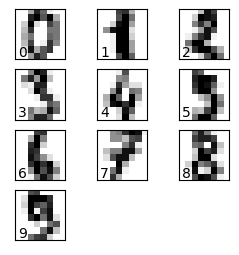

In [4]:
fig = plt.figure(figsize=(3, 3))
plt.gray()

# Добавить объекты графиков и отобразить в них первые 10 строк массива X, как матрицу 8х8 пикселей в сетке 3х4 
for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[i],[8,8]), interpolation='none')
    # Отобразить целевую метку класса для каждой картинки
    ax.text(0, 7, str(y[i]))

## 2. Кластеризация и оценка качества

2.1 Используя алгоритмы иерархической кластеризации и $K$ средних, получить разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [5]:
km = cluster.KMeans(n_clusters=10, n_init=100)
kmlabels = km.fit_predict(X)

print(kmlabels)
print(f"Полученные кластеры: {np.unique(kmlabels)}")
print(f"Размеры кластеров: {np.bincount(kmlabels + 1)}")

[8 4 4 ... 4 2 2]
Полученные кластеры: [0 1 2 3 4 5 6 7 8 9]
Размеры кластеров: [  0 182 147 247  85 225 175 169 209 179 179]


In [6]:
ac = cluster.AgglomerativeClustering(n_clusters=10, linkage='ward')
aclabels = ac.fit_predict(X)

print(aclabels)
print(f"Полученные кластеры: {np.unique(aclabels)}")
print(f"Размеры кластеров: {np.bincount(aclabels + 1)}")

[7 9 4 ... 4 1 4]
Полученные кластеры: [0 1 2 3 4 5 6 7 8 9]
Размеры кластеров: [  0 181 317 197 196 191 178 181 178  80  98]


2.2 Визуализировать центры кластеров, полученных каждым из двух алгоритмов (на сетке 3 $\times$ 4 с белым фоном и тёмными контурами).  
Прокомментировать: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- За центр кластера принять среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Для отбора наблюдений, входящих в кластер `i`, использовать индексацию по булевозначной маске. Маску получить из массива предсказанных номеров кластеров.  
- Значения пикселей центра кластера усреднять функцией `np.mean`.

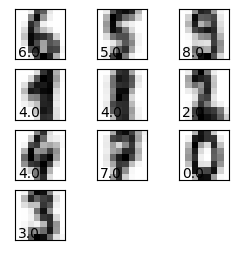

In [7]:
fig = plt.figure(figsize=(3, 3))

for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    # Выбор и усреднение записей из массива X по заданным индексам из массива кластеров
    ax.imshow(np.reshape(X[kmlabels == i].mean(axis=0),[8,8]), interpolation='none')
    # Отобразить усредненную целевую метку класса для каждого кластера
    ax.text(0, 7, str(y[kmlabels == i].mean().round()))

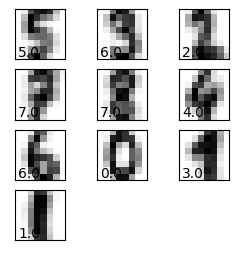

In [8]:
fig = plt.figure(figsize=(3, 3))

for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[aclabels == i].mean(axis=0),[8,8]), interpolation='none')
    ax.text(0, 7, str(y[aclabels == i].mean().round()))

*Выводы:*
- Оба алгоритма дают центры кластеров сравнимого качества (по схожести с исходными изображениями) 
- Результат для K-means: 7 совпадений, 1 близко (усредненное целевое значение 8 для изображения, которое ближе к 9), и 2 изображения далеки от своих целевых значений
- Результат для Агломеративной кластеризации: 6 совпадений, 1 близко (усредненное целевое значение 7 для изображения, которое ближе к 8), и 3 изображения далеки от своих целевых значений


2.3 В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход передается массив наблюдений и результат кластеризации.

Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. 
Посчитать силуэт. Посчитанные значения силуэта сохранить и визуализировать в виде графика в координатах: число $K$ / значение силуэта. 
 
При каком числе кластеров достигается максимум силуэта?

2.4 Повторить предыдущий пункт используя $V$-меру вместо силуэта.  
При каком числе кластеров достигается максимум $V$-меры?

In [9]:
km_silhouette_scores = []
ac_silhouette_scores = []

km_v_measure_scores = []
ac_v_measure_scores = []

K = range(2,21)

for i in K:
    clusters = cluster.KMeans(n_clusters=i, n_init=100).fit_predict(X)
    km_silhouette_scores.append(silhouette_score(X, clusters))
    km_v_measure_scores.append(v_measure_score(y, clusters))

    clusters = cluster.AgglomerativeClustering(n_clusters=i).fit_predict(X)
    ac_silhouette_scores.append(silhouette_score(X, clusters))
    ac_v_measure_scores.append(v_measure_score(y, clusters))

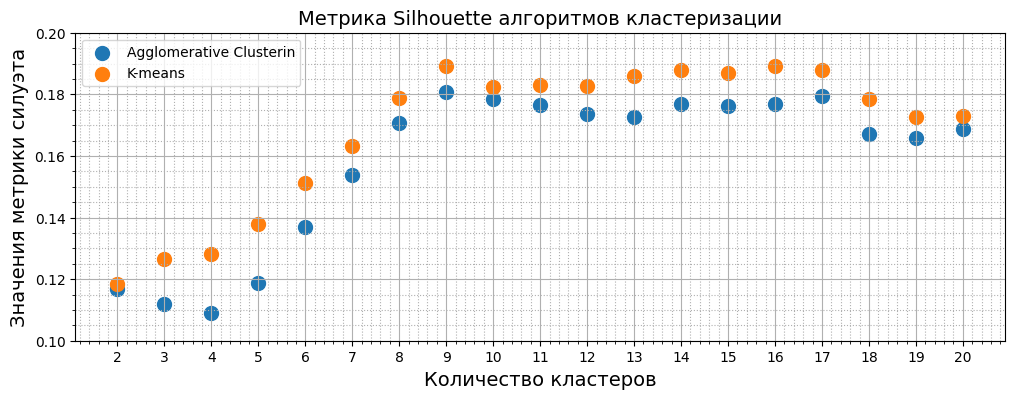

In [10]:
fig = plt.figure(figsize=(12, 4))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('Количество кластеров', fontsize=14)
plt.ylabel('Значения метрики силуэта', fontsize=14)
plt.title('Метрика Silhouette алгоритмов кластеризации', fontsize=14)
plt.scatter(x=K,y=ac_silhouette_scores,s=100, label='Agglomerative Clusterin')
plt.scatter(x=K,y=km_silhouette_scores,s=100, label='K-means')
plt.ylim([0.1,0.2])
plt.xticks(K);
plt.legend()
plt.show()

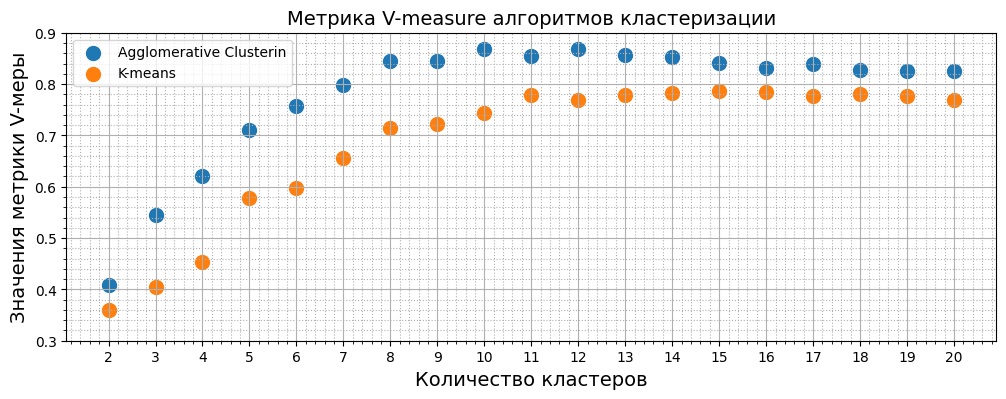

In [11]:
fig = plt.figure(figsize=(12, 4))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('Количество кластеров', fontsize=14)
plt.ylabel('Значения метрики V-меры', fontsize=14)
plt.title('Метрика V-measure алгоритмов кластеризации', fontsize=14)
plt.scatter(x=K,y=ac_v_measure_scores,s=100, label='Agglomerative Clusterin')
plt.scatter(x=K,y=km_v_measure_scores,s=100, label='K-means')
plt.ylim([0.3,0.9])
plt.xticks(K)
plt.legend()
plt.show()

# 3. Снижение размерности признакового пространства

3.1 Использовать класс `TruncatedSVD` из подмодуля `decomposition`.  
Выполнить сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков.  
В каждом случае выполнить иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров принять равным 10).  
Рассчитать значения силуэта и $V$-меры.  

Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [12]:
km_silhouette_scores = []
ac_silhouette_scores = []
db_silhouette_scores = []

km_v_measure_scores = []
ac_v_measure_scores = []
db_v_measure_scores = []

K = [2,5,10,15,20,25,30,35,40]
n_clusters = 10

for i in K:
    svd = TruncatedSVD(n_components=i, n_iter=7, random_state=42)
    X_svd = svd.fit_transform(X)

    clusters = cluster.KMeans(n_clusters=n_clusters, n_init=100).fit_predict(X_svd)
    km_silhouette_scores.append(silhouette_score(X_svd, clusters))
    km_v_measure_scores.append(v_measure_score(y, clusters))

    clusters = cluster.AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_svd)
    ac_silhouette_scores.append(silhouette_score(X_svd, clusters))
    ac_v_measure_scores.append(v_measure_score(y, clusters))

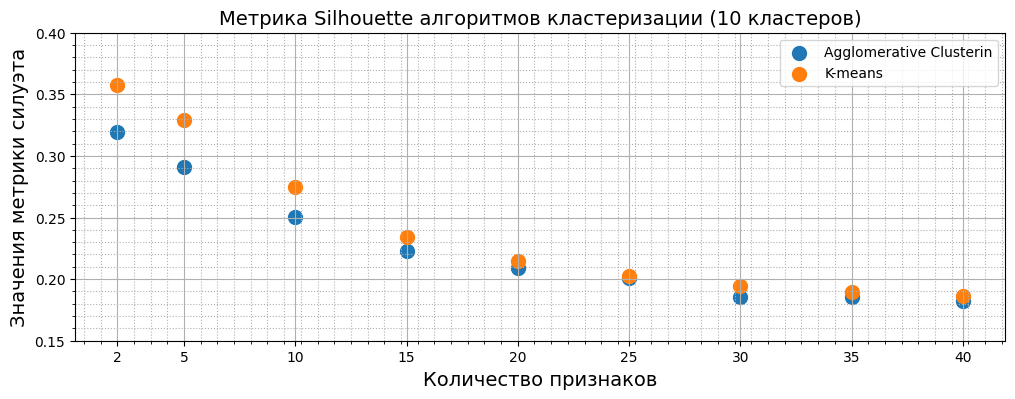

In [13]:
fig = plt.figure(figsize=(12, 4))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('Количество признаков', fontsize=14)
plt.ylabel('Значения метрики силуэта', fontsize=14)
plt.title('Метрика Silhouette алгоритмов кластеризации (10 кластеров)', fontsize=14)
plt.scatter(x=K,y=ac_silhouette_scores,s=100, label='Agglomerative Clusterin')
plt.scatter(x=K,y=km_silhouette_scores,s=100, label='K-means')
plt.ylim([0.15,0.4])
plt.xticks(K);
plt.legend()
plt.show()

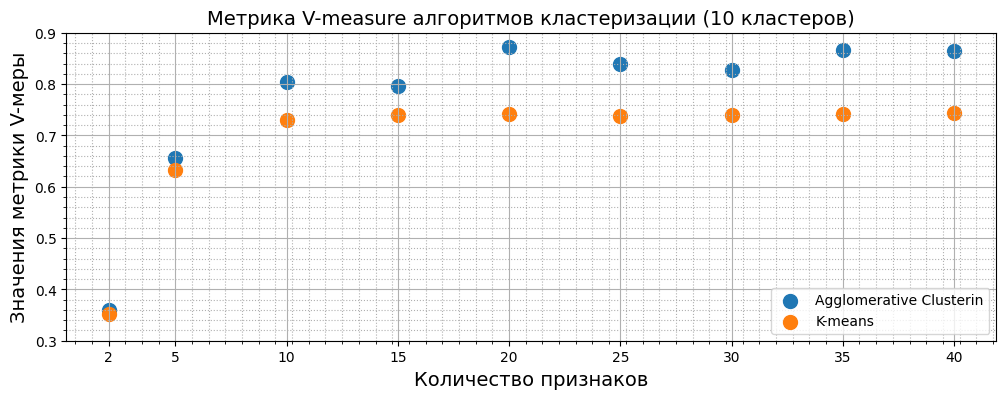

In [14]:
fig = plt.figure(figsize=(12, 4))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('Количество признаков', fontsize=14)
plt.ylabel('Значения метрики V-меры', fontsize=14)
plt.title('Метрика V-measure алгоритмов кластеризации (10 кластеров)', fontsize=14)
plt.scatter(x=K,y=ac_v_measure_scores,s=100, label='Agglomerative Clusterin')
plt.scatter(x=K,y=km_v_measure_scores,s=100, label='K-means')
plt.ylim([0.3,0.9])
plt.xticks(K)
plt.legend()
plt.show()

### Выводы:

- При снижении размерности до 25 признаков и ниже метрика Силуэта улучшается тем сильнее чем меньше признаков остается.
- При этом метрика V-меры существенно не изменяется.
    

Визуализируем результат понижения размерности методом TruncatedSVD

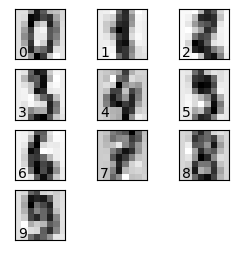

In [15]:
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)

X_svd = svd.fit_transform(X)
X_reconstructed_svd = svd.inverse_transform(X_svd)

fig = plt.figure(figsize=(3, 3))
for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X_reconstructed_svd[i],[8,8]), interpolation='none')
    ax.text(0, 7, str(y[i]))

А проверим как работает алгоритм DBSCAN на данных с пониженной размерностью !?

In [16]:
dblabels = cluster.DBSCAN(eps=8, min_samples=3,n_jobs=-1).fit_predict(X_svd)

print(dblabels)
print(f"Полученные кластеры: {np.unique(dblabels)}")
print(f"Размеры кластеров: {np.bincount(dblabels + 1)}")

[-1 -1 -1 ... -1 -1 -1]
Полученные кластеры: [-1  0  1  2  3  4  5  6  7  8  9]
Размеры кластеров: [1761    3    3    6    3    4    3    3    3    4    4]


Ну.. столько сэмплов в шум? ... так себе результат :(

Пострим, что с теми сэплами которые получилось классифицировать:

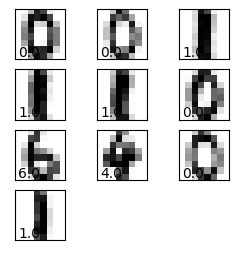

In [17]:
fig = plt.figure(figsize=(3, 3))

for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[dblabels == i].mean(axis=0),[8,8]), interpolation='none')
    ax.text(0, 7, str(y[dblabels == i].mean().round()))

Понятно... кроме кружечков и палочек ничего распознать не удалось :(

3.2 Использовать класс `TSNE` из подмодуля `manifold`.  
Выполнить tSNE-преобразование матрицы `X`, оставив 2 признака.  
Визуализировать данные в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси.  
Подсветить разными цветами группы точек, соответствующих разным цифрам.

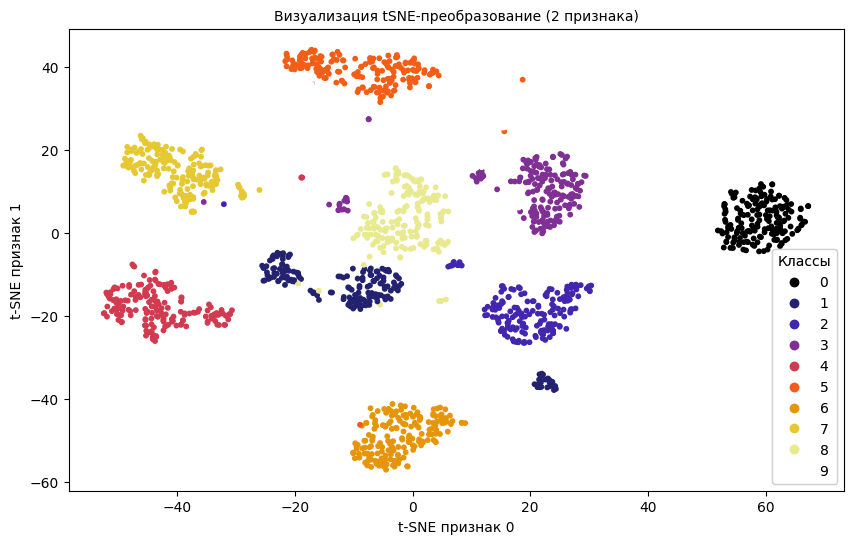

In [18]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42)
X_tsne = tsne.fit_transform(X)

colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Визуализация tSNE-преобразование (2 признака)', fontsize=10)
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='CMRmap', s=10)
legend = ax.legend(*scatter.legend_elements(), loc='lower right', title='Классы')
ax.add_artist(legend)

plt.show()

3.3 Для tSNE-преобразованных данных с 2 признаками выполнить иерархическую и $K$-means кластеризацию (число кластеров принять равным 10).  
Посчитать значения силуэта и $V$-меры.  

Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [19]:
clusters = cluster.KMeans(n_clusters=10, n_init=100).fit_predict(X_tsne)
print(f"KMeans Silhouette score : {silhouette_score(X_tsne, clusters)}")
print(f"KMeans V-measure score: {v_measure_score(y, clusters)}")

clusters = cluster.AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_tsne)
print(f"AgglomerativeClustering Silhouette score : {silhouette_score(X_tsne, clusters)}")
print(f"AgglomerativeClustering V-measure score: {v_measure_score(y, clusters)}")

KMeans Silhouette score : 0.6324402689933777
KMeans V-measure score: 0.9037986302169729
AgglomerativeClustering Silhouette score : 0.6196193695068359
AgglomerativeClustering V-measure score: 0.9089204132139508


Вывод:  Нет, значения метрик на преобразованных данных существенно не улучшились

3.4 Для самого лучшего разбиения (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), выполнить визуализацию картинками центров кластеров.  

Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

Решение: 
- в среднем, одно из лучших разбиении на кластеры получается на данных, преобразованных методом TruncatedSVD, при количестве признаков = 20
- Нет, ни при каком разбиении не получается добиться того, что бы кластер соответсвовал заданной цифре

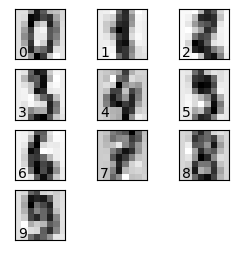

In [20]:
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)

X_svd = svd.fit_transform(X)
X_reconstructed_svd = svd.inverse_transform(X_svd)

fig = plt.figure(figsize=(3, 3))
for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X_reconstructed_svd[i],[8,8]), interpolation='none')
    ax.text(0, 7, str(y[i]))

In [21]:
# Выполнить кластеризацию
kmlabels = cluster.KMeans(n_clusters=10, n_init=100).fit_predict(X_svd)
aclabels = cluster.AgglomerativeClustering(n_clusters=10).fit_predict(X_svd)

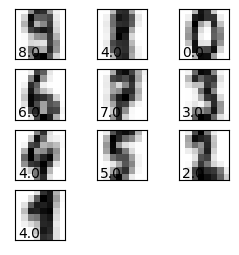

In [22]:
# Выполнить визуализацию центров кластеров, полученных методом K-средних
fig = plt.figure(figsize=(3, 3))
for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[kmlabels == i].mean(axis=0),[8,8]), interpolation='none')
    ax.text(0, 7, str(y[kmlabels == i].mean().round()))

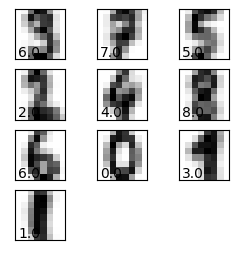

In [23]:
# Выполнить визуализацию центров кластеров, полученных методом AgglomerativeClustering
fig = plt.figure(figsize=(3, 3))
for i in range(10):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[aclabels == i].mean(axis=0),[8,8]), interpolation='none')
    ax.text(0, 7, str(y[aclabels == i].mean().round()))

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- `Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?`
- `Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?`

1. Один хрен, на тестируемых данных не выявлено явных преемуществ того или другого метода.  
При этом критерий V-меры дает лучшую оценку методу AgglomerativeClustering,
а критерий Силуэта дает лучшую оценку методу К-средих

2. Хотя, при снижении размерности признакового пространства, оценка по критерию Силуэта значительно улучшается,
но объективно это не дает никакого улучшения качества кластеризации на тестируемом наборе данных